In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Modular network implementation

In the following cells, I implement in a modular way a feedforward neural network. Please study the code -- many network implementations follow a similar pattern.

In [15]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)


In [16]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
    
    @property
    def parameters(self):
        return []
    
    @property
    def parameter_names(self):
        return []
    
    def get_gradients(self, dLdY, fprop_context):
        return []
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out, weight_init=None, bias_init=None, **kwargs):
        super(AffineLayer, self).__init__(**kwargs)
        if weight_init is None:
            #
            # TODO propose a default initialization scheme.
            # Type a sentence explaining why, and if you use a reference, 
            # cite it here
            #
            # https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2001-6.pdf
            weight_init = Uniform(width = 0.1)
        if bias_init is None:
            bias_init = Constant(0.0)
        
        self.W = weight_init.generate(self.rng, (num_out, num_in))
        self.b = bias_init.generate(self.rng, (num_out, 1))
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    @property
    def parameter_names(self):
        return ['W','b']
    
    def fprop(self, X):
        #Save X for later reusal
        fprop_context = dict(X=X)
        Y = np.dot(self.W, X) +  self.b
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        #
        # TODO: fill in gradient computation
        #
        dYdX = self.W
        #print "Affine shapes: ", dLdY.shape, " ", dYdX.shape
        dLdX = dLdY.T.dot(dYdX).T
        return dLdX
    
    def get_gradients(self, dLdY, fprop_context):
        X = fprop_context['X']
        dLdW = np.dot(dLdY, X.T)
        dLdb = dLdY.sum(1, keepdims=True)
        return [dLdW, dLdb]
    
class TanhLayer(Layer):
    def __init__(self, **kwargs):
        super(TanhLayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.tanh(X)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        #
        # Fill in proper gradient computation
        #
        dYdX = (1.0 - Y**2)
        #print "Tanh shapes: ", Y.shape, " ",dLdY.shape, " ", dYdX.shape
        return (dLdY * dYdX)

    
class ReLULayer(Layer):
    def __init__(self, **kwargs):
        super(ReLULayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.maximum(X, 0.0)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        #print "RELU shapes: ", Y.shape, " ", dLdY
        return dLdY * (Y>0)

    
class SoftMaxLayer(Layer):
    def __init__(self, **kwargs):
        super(SoftMaxLayer, self).__init__(**kwargs)
    
    def compute_probabilities(self, X):
        O = X - X.max(axis=0, keepdims=True)
        O = np.exp(O)
        O /= O.sum(axis=0, keepdims=True)
        return O
    
    def fprop_cost(self, X, Y):
        NS = X.shape[1]
        O = self.compute_probabilities(X)
        Cost = -1.0/NS * np.log(O[Y.ravel(), range(NS)]).sum()
        return Cost, O, dict(O=O, X=X, Y=Y)
    
    def bprop_cost(self, fprop_context):
        X = fprop_context['X']
        Y = fprop_context['Y']
        O = fprop_context['O']
        NS = X.shape[1]
        dLdX = O.copy()
        dLdX[Y, range(NS)] -= 1.0
        dLdX /= NS
        #print "SoftMax error ", dLdX.shape 
        return dLdX
    
class FeedForwardNet(object):
    def __init__(self, layers=None):
        if layers is None:
            layers = []
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
    
    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params
    
    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP[...] = newP
    
    @property
    def parameter_names(self):
        param_names = []
        for layer in self.layers:
            param_names += layer.parameter_names
        return param_names
    
    def fprop(self, X):
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
        return self.layers[-1].compute_probabilities(X)
    
    def get_cost_and_gradient(self, X, Y):
        fp_contexts = []
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
            fp_contexts.append(fp_context)
        
        L, O, fp_context = self.layers[-1].fprop_cost(X, Y)
        dLdX = self.layers[-1].bprop_cost(fp_context)
        
        dLdP = [] #gradient with respect to parameters
        for i in xrange(len(self.layers)-1):
            layer = self.layers[len(self.layers)-2-i]
            fp_context = fp_contexts[len(self.layers)-2-i]
            dLdP = layer.get_gradients(dLdX, fp_context) + dLdP
            dLdX = layer.bprop(dLdX, fp_context)
        return L, O, dLdP


In [26]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [29]:
dict = unpickle("../cifar10/data_batch_1")
for pic in 
print dict['data'][0:1024]

(10000, 3072)


In [21]:
#training algorithms. They change the network!
def GD(net, X, Y, alpha=1e-4, max_iters=1000000, tolerance=1e-6):
    """
    Simple batch gradient descent
    """
    old_L = np.inf
    for i in xrange(max_iters):
        L, O, gradients = net.get_cost_and_gradient(X, Y)
        if old_L < L:
            print "Iter: %d, loss increased!!" % (i,)
        if (old_L - L)<tolerance:
            print "Tolerance level reached exiting"
            break
        if i % 1000 == 0:
            err_rate = (O.argmax(0) != Y).mean()
            print "At iteration %d, loss %f, train error rate %f%%" % (i, L, err_rate*100)
        for P,G in zip(net.parameters, gradients):
            P -= alpha * G
        old_L = L

In [6]:
from sklearn import datasets
iris = datasets.load_iris()
IrisX = iris.data.T
IrisX = (IrisX - IrisX.mean(axis=1, keepdims=True)) / IrisX.std(axis=1, keepdims=True)
IrisY = iris.target.reshape(1,-1)

In [7]:
#
# Here we verify that the network can be trained on Irises.
# Most runs should result in 100% accurracy
#

net = FeedForwardNet([
        AffineLayer(4,10),
        TanhLayer(),
        AffineLayer(10,3),
        SoftMaxLayer()
        ])
GD(net, IrisX,IrisY, 1e-1, tolerance=1e-7, max_iters=50000)

At iteration 0, loss 1.101256, train error rate 93.333333%
At iteration 1000, loss 0.055549, train error rate 2.000000%
At iteration 2000, loss 0.044579, train error rate 2.000000%
At iteration 3000, loss 0.041862, train error rate 1.333333%
At iteration 4000, loss 0.040746, train error rate 1.333333%
At iteration 5000, loss 0.040121, train error rate 1.333333%
At iteration 6000, loss 0.039667, train error rate 1.333333%
At iteration 7000, loss 0.039265, train error rate 1.333333%
At iteration 8000, loss 0.038867, train error rate 1.333333%
At iteration 9000, loss 0.038459, train error rate 1.333333%
At iteration 10000, loss 0.038047, train error rate 1.333333%
At iteration 11000, loss 0.037643, train error rate 1.333333%
At iteration 12000, loss 0.037263, train error rate 1.333333%
At iteration 13000, loss 0.036914, train error rate 1.333333%
At iteration 14000, loss 0.036599, train error rate 1.333333%
At iteration 15000, loss 0.036313, train error rate 1.333333%
At iteration 16000, 

In [8]:
(net.fprop(IrisX).argmax(0) != IrisY).mean() *100

0.0

# SGD

Your job is to implement SGD training on MNIST with the following elements:
1. SGD + momentum
2. weight decay
3. early stopping

In overall, you should get below 2% trainig errors

## Reading data from Fuel

The following cell prepares the data pipeline in fuel. please see SGD template for usage example

In [9]:
zip([1,2],[3,5])

[(1, 3), (2, 5)]

In [29]:
from fuel.datasets.mnist import MNIST
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

MNIST.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (b.T for b in batch)], {}) )

mnist_train = MNIST(("train",), subset=slice(None,50000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
mnist_train_stream = DataStream.default_stream(
    mnist_train,
    iteration_scheme=ShuffledScheme(mnist_train.num_examples, 100))

                         
mnist_validation = MNIST(("train",), subset=slice(50000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
mnist_validation_stream = DataStream.default_stream(
    mnist_validation, iteration_scheme=SequentialScheme(mnist_validation.num_examples, 250))
mnist_test = MNIST(("test",))
mnist_test_stream = DataStream.default_stream(
    mnist_test, iteration_scheme=SequentialScheme(mnist_test.num_examples, 250))

In [2]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [3]:
cifar10_train1 = unpickle("../cifar10/data_batch_1")
cifar10_train2 = unpickle("../cifar10/data_batch_2")
cifar10_train3 = unpickle("../cifar10/data_batch_3")
cifar10_train4 = unpickle("../cifar10/data_batch_4")
cifar10_train5 = unpickle("../cifar10/data_batch_5")
cifar10_test = unpickle("../cifar10/test_batch")
meta = unpickle("../cifar10/batches.meta")
np.array(cifar10_train1['labels']).reshape(10000,1).shape

(10000, 1)

In [4]:
import h5py
f = h5py.File('../fuel/fuel/datasets/cifar10.hdf5', mode='w')
batch1_features = f.create_dataset('batch1_features', (10000, 3072), dtype='uint8')
batch1_features[...] = cifar10_train1['data']
batch1_targets = f.create_dataset('batch1_targets', (10000, 1), dtype='uint8')
batch1_targets[...] = np.array(cifar10_train1['labels']).reshape(10000,1)
batch2_features = f.create_dataset('batch2_features', (10000, 3072), dtype='uint8')
batch2_features[...] = cifar10_train2['data']
batch2_targets = f.create_dataset('batch2_targets', (10000, 1), dtype='uint8')
batch2_targets[...] = np.array(cifar10_train2['labels']).reshape(10000,1)
batch3_features = f.create_dataset('batch3_features', (10000, 3072), dtype='uint8')
batch3_features[...] = cifar10_train3['data']
batch3_targets = f.create_dataset('batch3_targets', (10000, 1), dtype='uint8')
batch3_targets[...] = np.array(cifar10_train3['labels']).reshape(10000,1)
batch4_features = f.create_dataset('batch4_features', (10000, 3072), dtype='uint8')
batch4_features[...] = cifar10_train4['data']
batch4_targets = f.create_dataset('batch4_targets', (10000, 1), dtype='uint8')
batch4_targets[...] = np.array(cifar10_train4['labels']).reshape(10000,1)
batch5_features = f.create_dataset('batch5_features', (10000, 3072), dtype='uint8')
batch5_features[...] = cifar10_train5['data']
batch5_targets = f.create_dataset('batch5_targets', (10000, 1), dtype='uint8')
batch5_targets[...] = np.array(cifar10_train5['labels']).reshape(10000,1)
test_features = f.create_dataset('test_features', (10000, 3072), dtype='uint8')
test_features[...] = cifar10_test['data']
test_targets = f.create_dataset('test_targets', (10000, 1), dtype='uint8')
test_targets[...] = np.array(cifar10_test['labels']).reshape(10000,1)


split_array = numpy.empty(
    12,
    dtype=numpy.dtype([
    ('split', 'a', 6),
    ('source', 'a', 15),
    ('start', numpy.int64, 1),
    ('stop', numpy.int64, 1),
    ('indices', h5py.special_dtype(ref=h5py.Reference)),
    ('available', numpy.bool, 1),
    ('comment', 'a', 1)]))
split_array[0:2]['split'] = 'train1'.encode('utf8')
split_array[2:4]['split'] = 'train2'.encode('utf8')
split_array[4:6]['split'] = 'train3'.encode('utf8')
split_array[6:8]['split'] = 'train4'.encode('utf8')
split_array[8:10]['split'] = 'train5'.encode('utf8')
split_array[10:12]['split'] = 'test'.encode('utf8')
split_array[0]['source'] = 'batch1_features'.encode('utf8')
split_array[1]['source'] = 'batch1_targets'.encode('utf8')
split_array[2]['source'] = 'batch2_features'.encode('utf8')
split_array[3]['source'] = 'batch2_targets'.encode('utf8')
split_array[4]['source'] = 'batch3_features'.encode('utf8')
split_array[5]['source'] = 'batch3_targets'.encode('utf8')
split_array[6]['source'] = 'batch4_features'.encode('utf8')
split_array[7]['source'] = 'batch4_targets'.encode('utf8')
split_array[8]['source'] = 'batch5_features'.encode('utf8')
split_array[9]['source'] = 'batch5_targets'.encode('utf8')
split_array[10]['source'] = 'test_features'.encode('utf8')
split_array[11]['source'] = 'test_targets'.encode('utf8')
split_array[0:12]['start'] = 0
split_array[0:12]['stop'] = 10000
split_array[:]['indices'] = h5py.Reference()
split_array[:]['available'] = True
split_array[:]['comment'] = '.'.encode('utf8')
f.attrs['split'] = split_array
f.flush()
f.close()

In [9]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (b.T for b in batch)], {}) )

cifar10_train = CIFAR10(("train1",), subset=slice(None,10000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
cifar10_train_stream = DataStream.default_stream(
    cifar10_train,
    iteration_scheme=ShuffledScheme(cifar10_train.num_examples, 100))
                                               
cifar10_validation = CIFAR10(("train2",), subset=slice(None,10000))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
cifar10_validation_stream = DataStream.default_stream(
    cifar10_validation, iteration_scheme=SequentialScheme(cifar10_validation.num_examples, 250))
cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(
    cifar10_test, iteration_scheme=SequentialScheme(cifar10_test.num_examples, 250))

In [11]:
print "The streams return batches containing %s" % (cifar10_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'batch1_features', u'batch1_targets')
Each trainin batch consits of a tuple containing:
 - an array of size (3072, 100) containing uint8
 - an array of size (1, 100) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (3072, 250) containing uint8
 - an array of size (1, 250) containing uint8


In [12]:
random.normal(1, 0.1, (3,3))

array([[ 1.09528022,  0.98029363,  1.09625913],
       [ 1.02509709,  0.84414134,  1.09693962],
       [ 0.92893431,  1.04985735,  0.95987327]])

In [25]:
#
# Please note, the code blow is able to train a SoftMax regression model on mnist to poor results (ca 8%test error), 
# you must improve it
#

from copy import deepcopy

def compute_error_rate(net, stream):
    num_errs = 0.0
    num_examples = 0
    for X, Y in stream.get_epoch_iterator():
        O = net.fprop(X)
        num_errs += (O.argmax(0) != Y).sum()
        num_examples += X.shape[1]
    return num_errs/num_examples

def SGD(net, train_stream, validation_stream, test_stream, lamb = 0, epsilon = 0):
    i=0
    e=0
    
    #initialize momentum variables
    #
    # TODO
    #
    # Hint: you need one valocity matrix for each parameter
    velocities = [None for P in net.parameters]
    
    best_valid_error_rate = np.inf
    best_params = deepcopy(net.parameters)
    best_params_epoch = 0
    
    train_erros = []
    train_loss = []
    validation_errors = []
    
    number_of_epochs = 300
    patience_expansion = 1.5
    
    try:
        while e<number_of_epochs: #This loop goes over epochs
            e += 1
            #First train on all data from this batch
            for X,Y in train_stream.get_epoch_iterator(): 
                i += 1
                L, O, gradients = net.get_cost_and_gradient(X, Y)
                err_rate = (O.argmax(0) != Y).mean()
                train_loss.append((i,L))
                train_erros.append((i,err_rate))
                if i % 100 == 0:
                    print "At minibatch %d, batch loss %f, batch error rate %f%%" % (i, L, err_rate*100)
                for P, V, G, N in zip(net.parameters, velocities, gradients, net.parameter_names):
                    
                    #
                    # TODO: set a learning rate
                    #
                    # Hint, use the iteration counter i
                    # alpha = TODO
                    alpha = (i+1.0)/(20.0*i)
                    #
                    # TODO: set the momentum constant 
                    # 
                    
                    # epsilon = TODO
                    
                    #
                    # TODO: implement velocity update in momentum
                    #
                    
                    # V[...] = TODO
                    if V == None:
                        V = 0.
                    V = epsilon*(V+G)
                    
                    if N=='W':
                        #
                        # TODO: implement the weight decay addition to gradient
                        #
                        #G += TODO
                        G += lamb * P
                    #
                    # TODO: set a more sensible learning rule here,
                    # using your learning rate schedule and momentum
                    #
                    #!!!!! Need to modify the actual parameter here! 
                    P += -5e-2  *(G+V)
            # After an epoch compute validation error
            val_error_rate = compute_error_rate(net, validation_stream)
            if val_error_rate < best_valid_error_rate:
                number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
                best_valid_error_rate = val_error_rate
                best_params = deepcopy(net.parameters)
                best_params_epoch = e
                validation_errors.append((i,val_error_rate))
            print "After epoch %d: valid_err_rate: %f%% currently going ot do %d epochs" %(
                e, val_error_rate, number_of_epochs)
            
    except KeyboardInterrupt:
        print "Setting network parameters from after epoch %d" %(best_params_epoch)
        net.parameters = best_params
        
        subplot(2,1,1)
        train_loss = np.array(train_loss)
        semilogy(train_loss[:,0], train_loss[:,1], label='batch train loss')
        legend()
        
        subplot(2,1,2)
        train_erros = np.array(train_erros)
        plot(train_erros[:,0], train_erros[:,1], label='batch train error rate')
        validation_errors = np.array(validation_errors)
        plot(validation_errors[:,0], validation_errors[:,1], label='validation error rate', color='r')
        ylim(0,0.2)
        legend()

At minibatch 100, batch loss 2.295357, batch error rate 90.000000%
After epoch 1: valid_err_rate: 0.901200% currently going ot do 300 epochs
At minibatch 200, batch loss 2.305973, batch error rate 92.000000%
After epoch 2: valid_err_rate: 0.899200% currently going ot do 300 epochs
At minibatch 300, batch loss 2.307586, batch error rate 84.000000%
After epoch 3: valid_err_rate: 0.901300% currently going ot do 300 epochs
At minibatch 400, batch loss 2.301503, batch error rate 91.000000%
After epoch 4: valid_err_rate: 0.901300% currently going ot do 300 epochs
At minibatch 500, batch loss 2.311094, batch error rate 89.000000%
After epoch 5: valid_err_rate: 0.898700% currently going ot do 300 epochs
At minibatch 600, batch loss 2.310238, batch error rate 89.000000%
After epoch 6: valid_err_rate: 0.898900% currently going ot do 300 epochs
At minibatch 700, batch loss 2.304056, batch error rate 94.000000%
After epoch 7: valid_err_rate: 0.900600% currently going ot do 300 epochs
At minibatch 

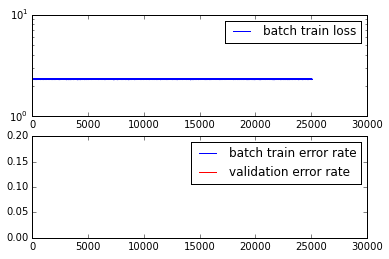

In [26]:
#
# TODO: pick a network architecture here. The one below is just 
# softmax regression
#

net = FeedForwardNet([
        AffineLayer(3072,500),
        ReLULayer(),
        AffineLayer(500,20),
        TanhLayer(),
        AffineLayer(20,10),
        SoftMaxLayer()
        ])
SGD(net, cifar10_train_stream, cifar10_validation_stream, cifar10_test_stream, 0.0001)

print "Test error rate: %f" % (compute_error_rate(net, cifar10_test_stream), )

In [27]:

compute_error_rate(net, cifar10_test_stream)

0.8999